<a href="https://colab.research.google.com/github/RicoStaedeli/NLP2025_CQG/blob/main/5_Evaluation_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [1]:
from google.colab import userdata
import os

In [2]:
token = userdata.get('GITHUB')
repo_url = f"https://{token}@github.com/RicoStaedeli/NLP2025_CQG.git"

!git clone {repo_url}


os.chdir("NLP2025_CQG")
!ls

Cloning into 'NLP2025_CQG'...
remote: Enumerating objects: 1927, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 1927 (delta 306), reused 222 (delta 180), pack-reused 1530 (from 1)
Receiving objects: 100% (1927/1927), 51.98 MiB | 6.44 MiB/s, done.
Resolving deltas: 100% (1160/1160), done.
Updating files: 100% (117/117), done.
1_a_Generate_DPO_Dataset.ipynb	      Development
1_Information_preprocessing.md	      Doc
1_Preprocessing.ipynb		      Evaluation
2_Baseline_Generation.ipynb	      INFORMATION.md
2_Information_Baseline_Generation.md  LICENSE
3_Evaluation.ipynb		      Logs
4_Finetuned_Generation.ipynb	      README.md
5_Evaluation_Analytics.ipynb	      Training
Data


In [3]:
import json

baseline_file = "results_Meta-Llama-3.1-8B-Instruct_schema_prompt_eval"
sft_file = "results_Meta-Llama-3.1-1B-Instruct_SFT_2_schema_prompt_eval"
dpo_file = "results_Meta-Llama-3.1-8B-Instruct_DPO_schema_prompt_eval"
dpo_sft_file = "results_Meta-Llama-3.1-8B-Instruct_SFT_DPO_schema_prompt_eval"
orpo_file = "results_Meta-Llama-3.1-8B-Instruct_ORPO_schema_prompt_eval"
orpo_sft_file = "results_Meta-Llama-3.1-8B-Instruct_ORPO_SFT_eval"

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/Finals/{baseline_file}.json"), "r", encoding="utf-8") as f:
    baseline_data = json.load(f)

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/Finals/{sft_file}.json"), "r", encoding="utf-8") as f:
    sft_data = json.load(f)

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/Finals/{dpo_file}.json"), "r", encoding="utf-8") as f:
    dpo_data = json.load(f)

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/Finals/{dpo_sft_file}.json"), "r", encoding="utf-8") as f:
    dpo_sft_data = json.load(f)

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/Finals/{orpo_file}.json"), "r", encoding="utf-8") as f:
    orpo_data = json.load(f)

# with open(os.path.join(os.getcwd(), f"Evaluation/Scored/Finals/{orpo_sft_file}.json"), "r", encoding="utf-8") as f:
#     orpo_sft_data = json.load(f)

raw_data = [baseline_data, sft_data, dpo_data, dpo_sft_data,orpo_data]

In [4]:
import pandas as pd

dfs = []
for data in raw_data:
  rows = []
  for entry_id, entry_data in data.items():
      context = entry_data['input']
      for cq in entry_data['cqs']:
          row = {
              "id": entry_id,
              "input": context,
              "schema": cq["schema"],
              "question": cq["cq"],
              "CauseToEffect": cq["CauseToEffect"],
              "ExpertOpinion": cq["ExpertOpinion"],
              "Analogy": cq["Analogy"],
              "FearAppeal": cq["FearAppeal"],
              "is_critical": cq["is_critical"],
              "passed_rules": cq["passed_rules"],
              "in_context": cq["in_context"],
              "sim_label": cq["sim_label"],
              "sim_score": cq["sim_score"],
              "bleurt_label": cq["bleurt_label"],
              "bleurt_score": cq["bleurt_score"]
          }
          rows.append(row)
  dfs.append(pd.DataFrame(rows))

model_names = ["Baseline", "SFT", "DPO", "DPO_SFT","ORPO"]

## Analysis

1. baseline (index 0)
2. sft (index 1)
3. dpo (index 2)
4. dpo with sft (index 3)

In [5]:
summary = []

for i, df in enumerate(dfs):
    total = len(df)

    critical_count = df['is_critical'].sum()
    in_context_count = df['in_context'].sum()

    critical_and_in_context = df[(df['is_critical'] == True) & (df['in_context'] == True)]
    critical_and_in_context_count = len(critical_and_in_context)

    sim_count = len(df[df["sim_label"] == "Useful"])
    bleurt_count = len(df[df["bleurt_label"] == "Useful"])

    summary.append({
        'Model': model_names[i],
        'Total Entries': total,
        'Critical Count': critical_count,
        '% Critical': (critical_count / total) * 100,
        'In Context Count': in_context_count,
        '% In Context': (in_context_count / total) * 100,
        'Critical & In Context Count': critical_and_in_context_count,
        '% Critical & In Context': (critical_and_in_context_count / total) * 100,
        'Sim Useful Count': sim_count,
        '% Sim Useful': (sim_count / total) * 100,
        'BLEURT Useful Count': bleurt_count,
        '% BLEURT Useful': (bleurt_count / total) * 100
    })

summary_df = pd.DataFrame(summary)

styler = summary_df.style.background_gradient(cmap='Blues', subset=[
    '% Critical', '% In Context', '% Critical & In Context', '% Sim Useful', '% BLEURT Useful'
])

styler = styler.format({
    'Total Entries': '{:,}',
    'Critical Count': '{:,}',
    'In Context Count': '{:,}',
    'Critical & In Context Count': '{:,}',
    'Sim Useful Count': '{:,}',
    'BLEURT Useful Count': '{:,}',
    '% Critical': '{:.1f}%',
    '% In Context': '{:.1f}%',
    '% Critical & In Context': '{:.1f}%',
    '% Sim Useful': '{:.1f}%',
    '% BLEURT Useful': '{:.1f}%'
})

display(styler)

,Model,Total Entries,Critical Count,% Critical,In Context Count,% In Context,Critical & In Context Count,% Critical & In Context,Sim Useful Count,% Sim Useful,BLEURT Useful Count,% BLEURT Useful
0,Baseline,744,237,31.9%,472,63.4%,132,17.7%,519,69.8%,3,0.4%
1,SFT,744,486,65.3%,488,65.6%,281,37.8%,500,67.2%,0,0.0%
2,DPO,744,185,24.9%,536,72.0%,135,18.1%,536,72.0%,2,0.3%
3,DPO_SFT,744,229,30.8%,546,73.4%,154,20.7%,554,74.5%,3,0.4%
4,ORPO,744,210,28.2%,565,75.9%,154,20.7%,582,78.2%,4,0.5%


Score distribution over all questions

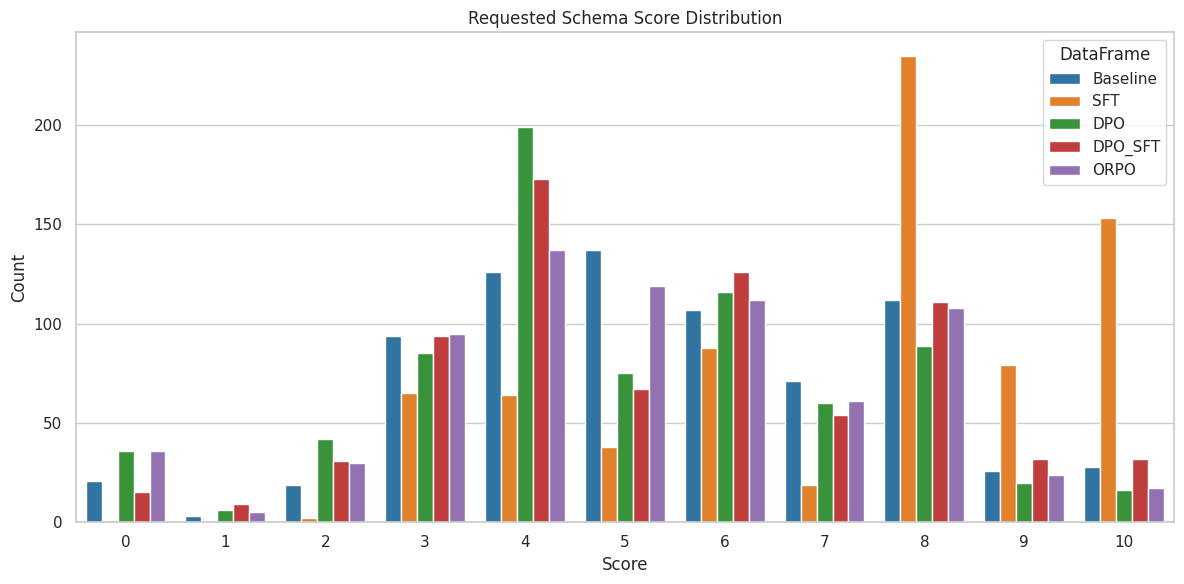

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plot_data = []

for model_name, df in zip(model_names, dfs):
    if 'schema_score' not in df.columns:
        df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

    capped_scores = df['schema_score'].round().clip(upper=10).astype(int)

    score_counts = capped_scores.value_counts().sort_index()

    for score, count in score_counts.items():
        plot_data.append({'Score': score, 'Count': count, 'DataFrame': model_name})

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Score', y='Count', hue='DataFrame', palette='tab10')

plt.title('Requested Schema Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(0, 11))
plt.legend(title='DataFrame')
plt.tight_layout()
plt.show()

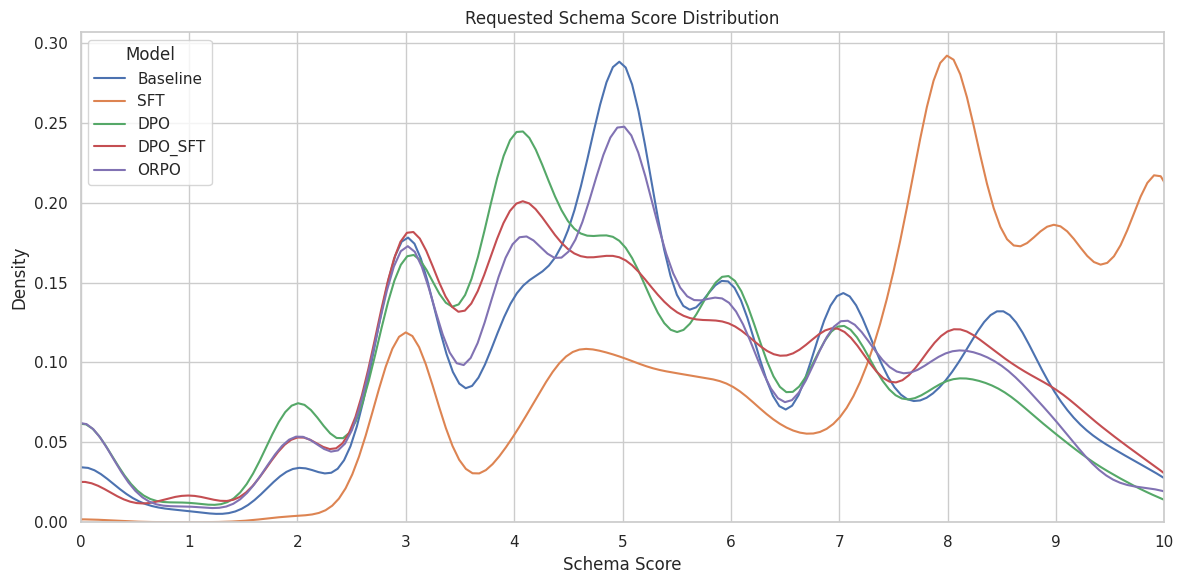

In [7]:
sns.set(style="whitegrid")

# Ensure schema_score exists for each DataFrame
for df in dfs:
    if 'schema_score' not in df.columns:
        df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

plt.figure(figsize=(12, 6))

# Plot KDE for each model
for model_name, df in zip(model_names, dfs):
    sns.kdeplot(
        data=df,
        x='schema_score',
        bw_adjust=0.5,  # Adjust bandwidth for smoothing (tune as needed)
        label=model_name,
        fill=False  # set to True if you want filled area
    )

plt.title('Requested Schema Score Distribution')
plt.xlabel('Schema Score')
plt.ylabel('Density')
plt.xlim(0, 10)
plt.xticks(range(0, 11))
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [8]:
stats_data = []

for model_name, df in zip(model_names, dfs):
    # Ensure schema_score column exists
    if 'schema_score' not in df.columns:
        df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

    # Compute statistics
    mean_score = df['schema_score'].mean()
    median_score = df['schema_score'].median()
    std_dev = df['schema_score'].std()

    stats_data.append({
        'Model': model_name,
        'Mean': mean_score,
        'Median': median_score,
        'Std Dev': std_dev
    })

# Create a DataFrame with the results
stats_df = pd.DataFrame(stats_data)

# Optional: format nicely
stats_df = stats_df.round(2)
display(stats_df)

,Model,Mean,Median,Std Dev
0,Baseline,5.49,5.0,2.19
1,SFT,7.28,8.0,2.21
2,DPO,4.96,5.0,2.25
3,DPO_SFT,5.40,5.0,2.27
4,ORPO,5.17,5.0,2.28


### Context & Rule check

### Core Analysis

In [9]:
for model_name, df in zip(model_names, dfs):
    df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

    critical_summary = (
        df.groupby('schema')['is_critical']
        .agg(Total='count', Critical='sum')
        .reset_index()
    )
    critical_summary['% Critical'] = (critical_summary['Critical'] / critical_summary['Total']) * 100

    score_stats = (
        df.groupby('schema')['schema_score']
        .agg(Average_Score='mean', Median_Score='median', Std_Dev='std', Min_Score='min', Max_Score='max')
        .reset_index()
    )

    in_context_counts = (
        df[df['in_context'] == True]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Count')
    )

    in_context_critical_counts = (
        df[(df['in_context'] == True) & (df['is_critical'] == True)]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Critical_Count')
    )

    combined_summary = critical_summary.merge(score_stats, on='schema', how='left')
    combined_summary = combined_summary.merge(in_context_counts, on='schema', how='left')
    combined_summary = combined_summary.merge(in_context_critical_counts, on='schema', how='left')

    combined_summary[['In_Context_Count', 'In_Context_Critical_Count']] = combined_summary[
        ['In_Context_Count', 'In_Context_Critical_Count']
    ].fillna(0).astype(int)

    combined_summary['% In Context'] = (combined_summary['In_Context_Count'] / combined_summary['Total']) * 100
    combined_summary['% In Context & Critical'] = (combined_summary['In_Context_Critical_Count'] / combined_summary['Total']) * 100

    combined_summary = combined_summary.sort_values(by='schema').reset_index(drop=True)

    pos_gradient_cols = ['% Critical', 'Average_Score', 'Median_Score', '% In Context', '% In Context & Critical']
    neg_gradient_cols = ['Std_Dev']

    styler = combined_summary.style
    styler = styler.background_gradient(cmap='Greens', subset=pos_gradient_cols)
    styler = styler.background_gradient(cmap='Reds_r', subset=neg_gradient_cols)
    styler = styler.format({
        'Average_Score': '{:.2f}',
        'Median_Score': '{:.2f}',
        'Std_Dev': '{:.2f}',
        '% Critical': '{:.1f}%',
        '% In Context': '{:.1f}%',
        '% In Context & Critical': '{:.1f}%'
    })

    print(f"Summary Table for {model_name}")
    display(styler)


Summary Table for Baseline


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,103,55.4%,6.69,7.25,1.87,4.000000,10.000000,108,56,58.1%,30.1%
1,CauseToEffect,186,38,20.4%,5.21,5.00,2.45,0.000000,10.000000,122,24,65.6%,12.9%
2,ExpertOpinion,186,82,44.1%,5.80,6.00,2.08,0.000000,10.000000,112,41,60.2%,22.0%
3,FearAppeal,186,14,7.5%,4.25,4.00,1.51,2.000000,10.000000,130,11,69.9%,5.9%


Summary Table for SFT


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,99,53.2%,7.11,7.50,2.09,3.000000,10.000000,124,60,66.7%,32.3%
1,CauseToEffect,186,147,79.0%,7.81,8.00,1.65,0.000000,10.000000,109,81,58.6%,43.5%
2,ExpertOpinion,186,181,97.3%,8.72,9.00,1.03,2.000000,10.500000,115,113,61.8%,60.8%
3,FearAppeal,186,59,31.7%,5.49,5.00,2.42,2.000000,10.000000,140,27,75.3%,14.5%


Summary Table for DPO


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,61,32.8%,5.73,5.00,1.81,3.000000,10.000000,131,45,70.4%,24.2%
1,CauseToEffect,186,42,22.6%,4.58,4.00,2.71,0.000000,10.000000,135,30,72.6%,16.1%
2,ExpertOpinion,186,71,38.2%,5.40,6.00,2.40,0.000000,10.000000,129,52,69.4%,28.0%
3,FearAppeal,186,11,5.9%,4.15,4.00,1.52,2.000000,10.000000,141,8,75.8%,4.3%


Summary Table for DPO_SFT


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,62,33.3%,6.01,5.50,1.82,2.500000,9.500000,133,44,71.5%,23.7%
1,CauseToEffect,186,53,28.5%,5.19,5.00,2.72,0.000000,10.000000,149,39,80.1%,21.0%
2,ExpertOpinion,186,96,51.6%,6.12,7.00,2.30,0.000000,10.000000,123,56,66.1%,30.1%
3,FearAppeal,186,18,9.7%,4.28,4.00,1.60,2.000000,10.000000,141,15,75.8%,8.1%


Summary Table for ORPO


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,85,45.7%,6.37,5.50,1.76,4.000000,10.000000,136,66,73.1%,35.5%
1,CauseToEffect,186,29,15.6%,4.16,4.75,2.82,0.000000,10.000000,148,23,79.6%,12.4%
2,ExpertOpinion,186,82,44.1%,5.93,6.00,1.89,0.000000,11.000000,127,55,68.3%,29.6%
3,FearAppeal,186,14,7.5%,4.23,4.00,1.53,2.000000,10.000000,154,10,82.8%,5.4%


In [10]:
all_summaries = []

for i, df in enumerate(dfs):
    df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

    critical_summary = (
        df.groupby('schema')['is_critical']
        .agg(Total='count', Critical='sum')
        .reset_index()
    )
    critical_summary['% Critical'] = (critical_summary['Critical'] / critical_summary['Total']) * 100

    score_stats = (
        df.groupby('schema')['schema_score']
        .agg(Average_Score='mean', Median_Score='median', Std_Dev='std', Min_Score='min', Max_Score='max')
        .reset_index()
    )

    in_context_counts = (
        df[df['in_context'] == True]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Count')
    )

    in_context_critical_counts = (
        df[(df['in_context'] == True) & (df['is_critical'] == True)]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Critical_Count')
    )

    combined = critical_summary.merge(score_stats, on='schema', how='left')
    combined = combined.merge(in_context_counts, on='schema', how='left')
    combined = combined.merge(in_context_critical_counts, on='schema', how='left')

    combined[['In_Context_Count', 'In_Context_Critical_Count']] = combined[
        ['In_Context_Count', 'In_Context_Critical_Count']
    ].fillna(0).astype(int)

    combined['% In Context'] = (combined['In_Context_Count'] / combined['Total']) * 100
    combined['% In Context & Critical'] = (combined['In_Context_Critical_Count'] / combined['Total']) * 100

    combined['Model'] = model_names[i]
    all_summaries.append(combined)

combined_all = pd.concat(all_summaries)

schemas = sorted(combined_all['schema'].unique())

metrics = ['Average_Score', 'Median_Score', 'Std_Dev', '% Critical', '% In Context', '% In Context & Critical']

for schema in schemas:
    schema_df = combined_all[combined_all['schema'] == schema].set_index('Model')[metrics]

    numeric_cols = schema_df.select_dtypes(include='number').columns
    percent_cols = [col for col in numeric_cols if '%' in col]
    float_cols = [col for col in numeric_cols if '%' not in col]

    styler = schema_df.style
    styler = styler.background_gradient(cmap='Greens', subset=numeric_cols)
    styler = styler.format('{:.2f}', subset=float_cols)
    styler = styler.format('{:.1f}%', subset=percent_cols)

    print(f"\n ### Schema: {schema}")
    display(styler)



 ### Schema: Analogy


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,6.69,7.25,1.87,55.4%,58.1%,30.1%
SFT,7.11,7.50,2.09,53.2%,66.7%,32.3%
DPO,5.73,5.00,1.81,32.8%,70.4%,24.2%
DPO_SFT,6.01,5.50,1.82,33.3%,71.5%,23.7%
ORPO,6.37,5.50,1.76,45.7%,73.1%,35.5%



 ### Schema: CauseToEffect


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,5.21,5.00,2.45,20.4%,65.6%,12.9%
SFT,7.81,8.00,1.65,79.0%,58.6%,43.5%
DPO,4.58,4.00,2.71,22.6%,72.6%,16.1%
DPO_SFT,5.19,5.00,2.72,28.5%,80.1%,21.0%
ORPO,4.16,4.75,2.82,15.6%,79.6%,12.4%



 ### Schema: ExpertOpinion


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,5.80,6.00,2.08,44.1%,60.2%,22.0%
SFT,8.72,9.00,1.03,97.3%,61.8%,60.8%
DPO,5.40,6.00,2.40,38.2%,69.4%,28.0%
DPO_SFT,6.12,7.00,2.30,51.6%,66.1%,30.1%
ORPO,5.93,6.00,1.89,44.1%,68.3%,29.6%



 ### Schema: FearAppeal


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,4.25,4.00,1.51,7.5%,69.9%,5.9%
SFT,5.49,5.00,2.42,31.7%,75.3%,14.5%
DPO,4.15,4.00,1.52,5.9%,75.8%,4.3%
DPO_SFT,4.28,4.00,1.60,9.7%,75.8%,8.1%
ORPO,4.23,4.00,1.53,7.5%,82.8%,5.4%


Distribution of each Schema

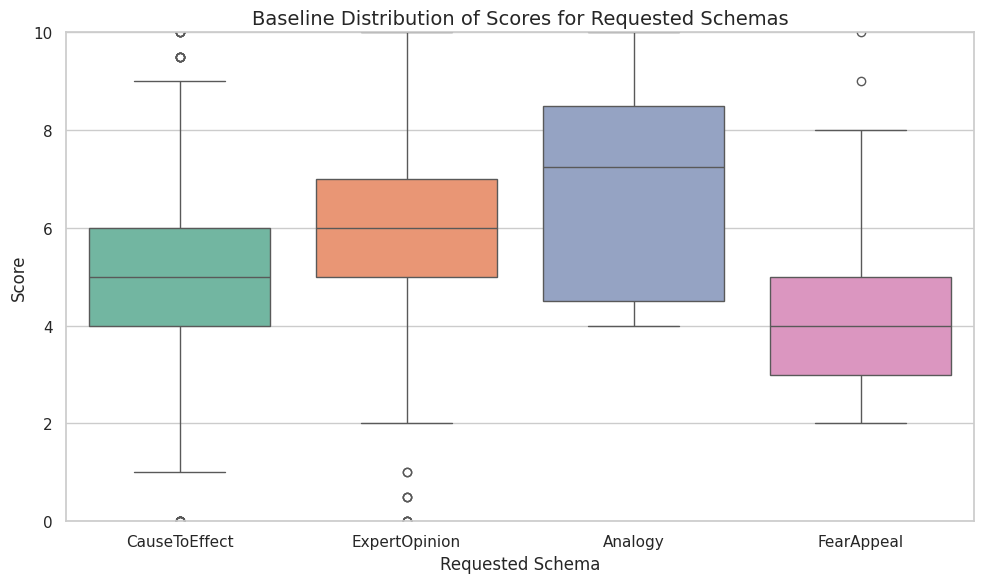

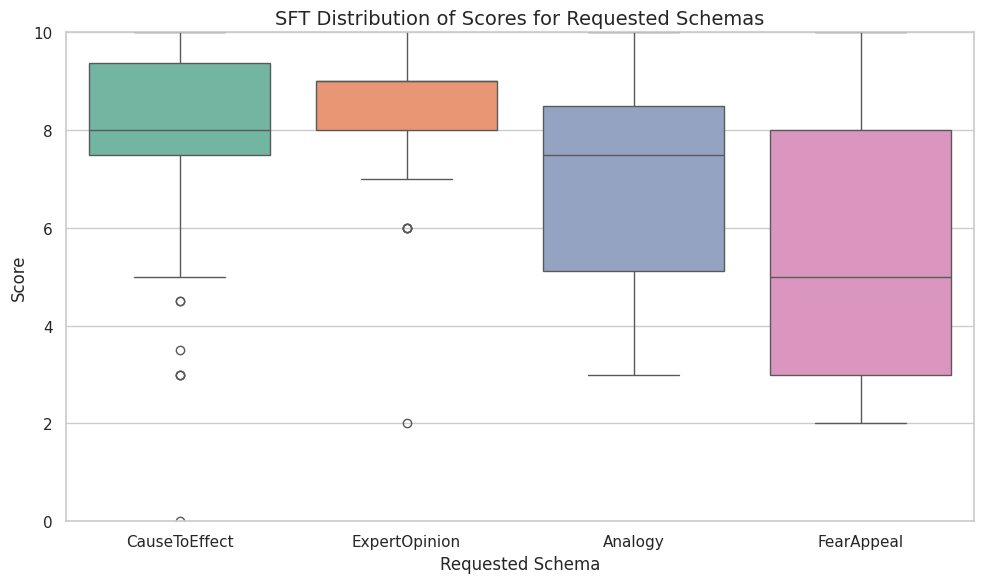

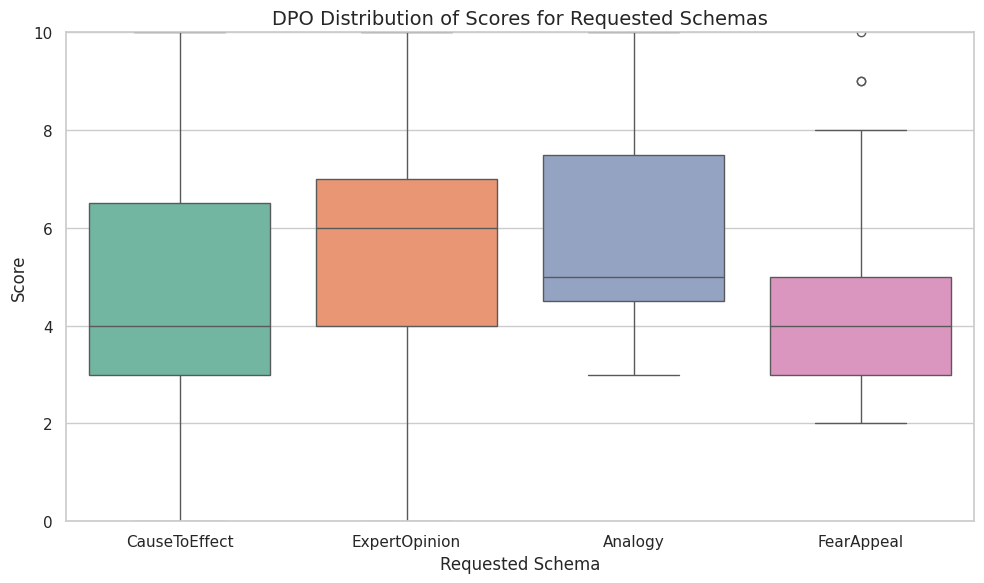

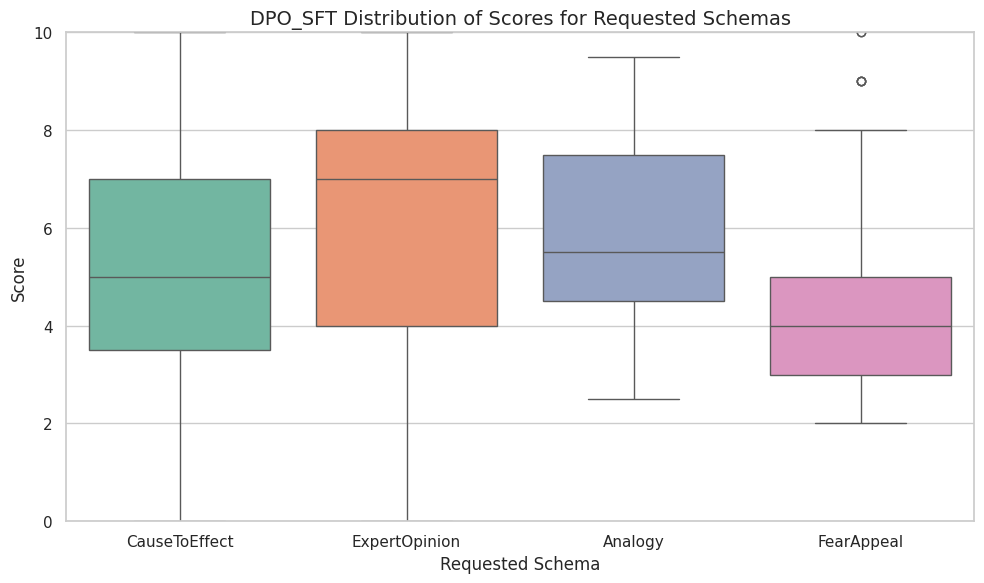

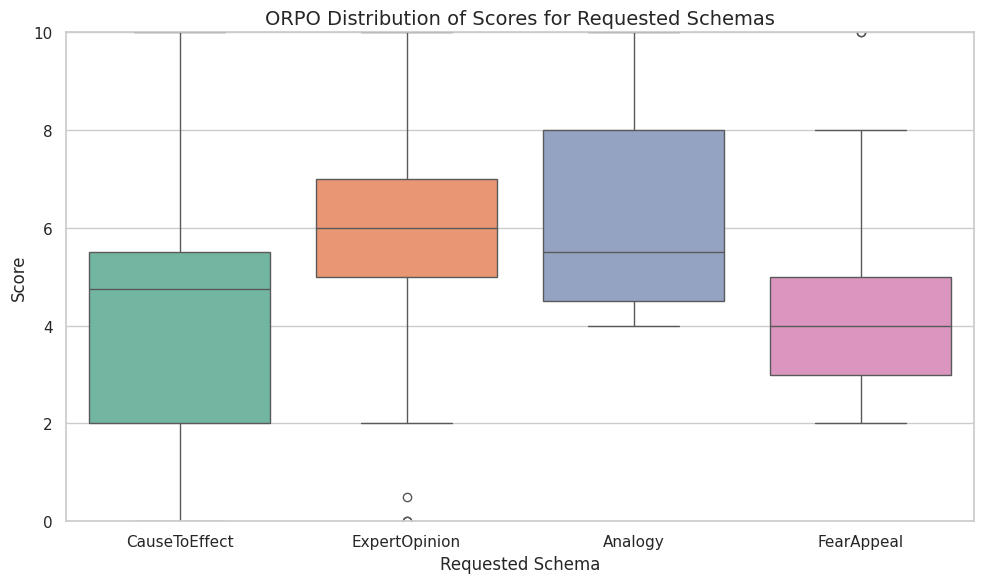

In [11]:
for model_name, df in zip(model_names, dfs):

  df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

  sns.set(style="whitegrid")

  plt.figure(figsize=(10, 6))
  sns.boxplot(x='schema', y='schema_score', data=df, hue='schema', palette='Set2', legend=False)

  plt.title(f'{model_name} Distribution of Scores for Requested Schemas', fontsize=14)
  plt.xlabel('Requested Schema')
  plt.ylabel('Score')
  plt.ylim(0, 10)
  plt.tight_layout()
  plt.show()

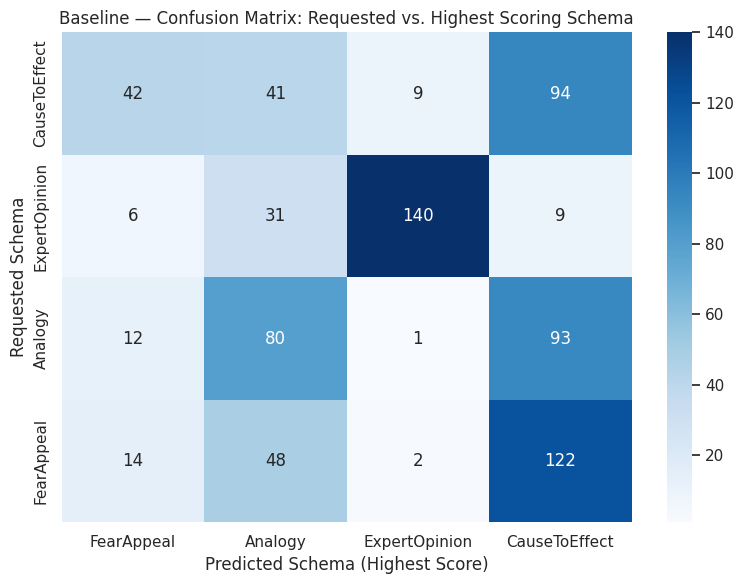

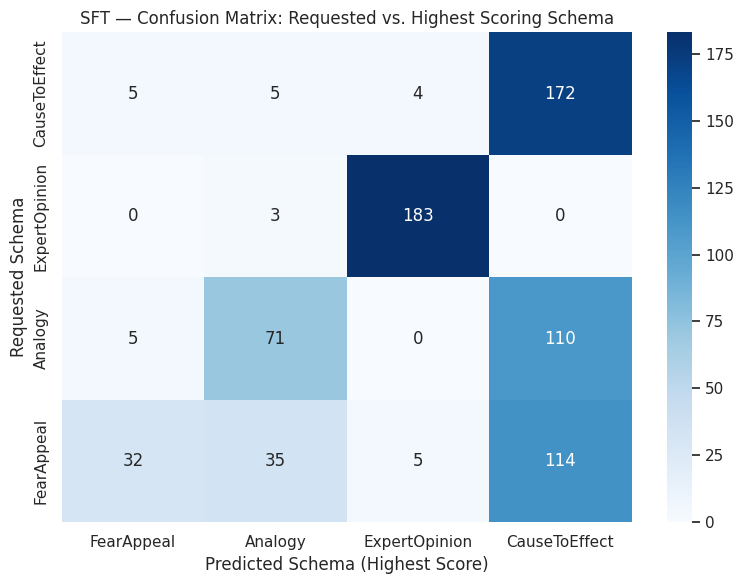

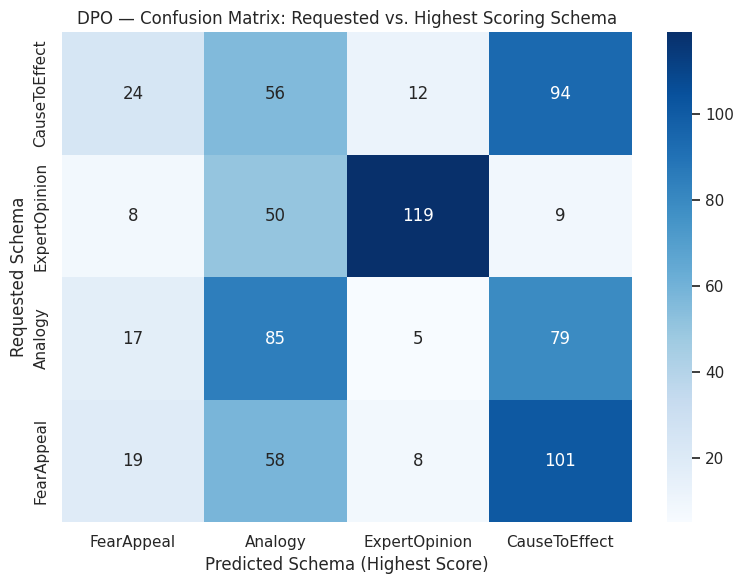

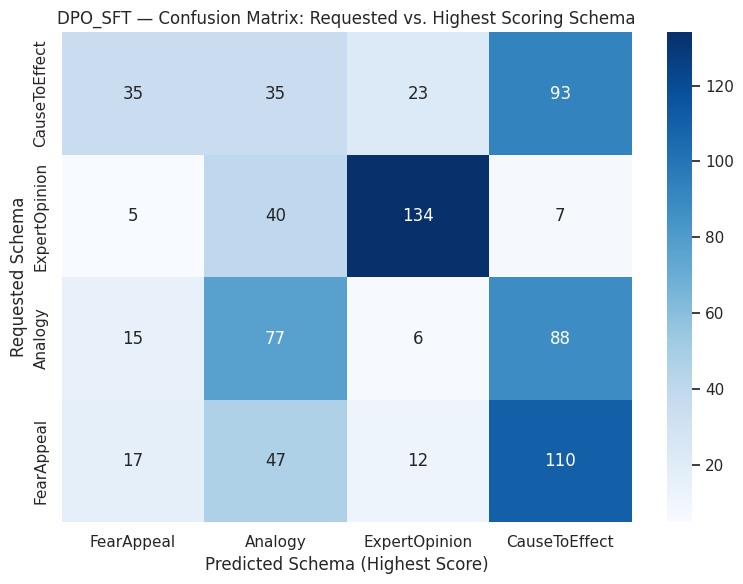

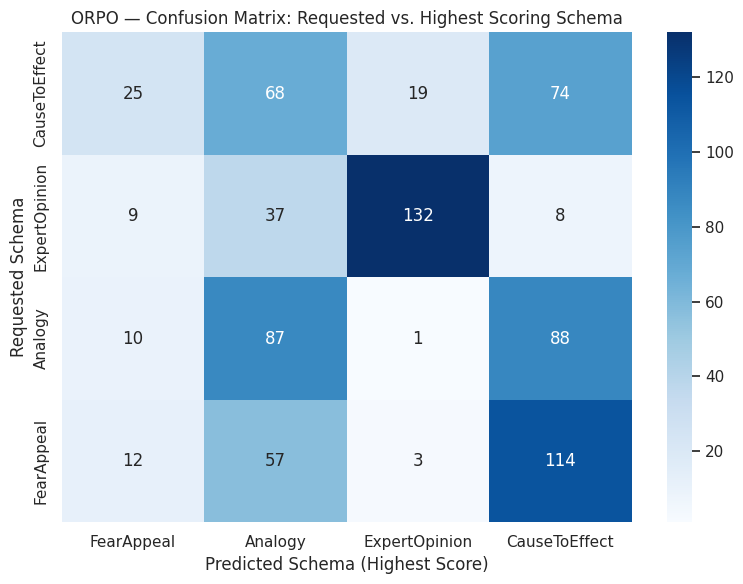

In [12]:
from sklearn.metrics import confusion_matrix

schemas = ['CauseToEffect', 'ExpertOpinion', 'Analogy', 'FearAppeal']
reversed_schemas = schemas[::-1]
model_names = ["Baseline", "SFT", "DPO", "DPO_SFT","ORPO"]

for model_name, df in zip(model_names, dfs):
    df['predicted_schema'] = df[schemas].idxmax(axis=1)

    cm = confusion_matrix(df['schema'], df['predicted_schema'], labels=schemas)

    cm_reversed = cm[:, ::-1]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_reversed, annot=True, fmt='d', cmap='Blues',
                xticklabels=reversed_schemas, yticklabels=schemas)

    plt.xlabel('Predicted Schema (Highest Score)')
    plt.ylabel('Requested Schema')
    plt.title(f'{model_name} — Confusion Matrix: Requested vs. Highest Scoring Schema')
    plt.tight_layout()
    plt.show()


### Edge case Analysis

In [13]:
threshold = 7
rows = []
for i, df in enumerate(dfs):
    high_scores_count = (df[schemas] >= threshold).sum(axis=1)
    multiple_high_scores = (high_scores_count >= 2).sum()

    # Count rows with multiple scores >= 7 AND is_critical True
    multiple_high_and_critical = ((high_scores_count >= 2) & (df['is_critical'] == True)).sum()

    total = len(df)
    percent_multiple = (multiple_high_scores / total) * 100
    percent_multiple_and_critical = (multiple_high_and_critical / total) * 100

    rows.append({
        'Model': model_names[i],
        'Total Entries': total,
        'Entries with ≥2 Scores ≥7': multiple_high_scores,
        'Percentage': percent_multiple,
        'Entries with ≥2 Scores ≥7 AND Critical': multiple_high_and_critical,
        'Percentage (≥2 Scores ≥7 & Critical)': percent_multiple_and_critical
    })

summary_df = pd.DataFrame(rows)

# Style and display
styled = summary_df.style \
    .background_gradient(subset=['Entries with ≥2 Scores ≥7',
                                 'Percentage',
                                 'Entries with ≥2 Scores ≥7 AND Critical',
                                 'Percentage (≥2 Scores ≥7 & Critical)'], cmap='Greens') \
    .format({
        'Percentage': '{:.2f}%',
        'Percentage (≥2 Scores ≥7 & Critical)': '{:.2f}%'
    }) \
    .set_properties(subset=['Percentage', 'Percentage (≥2 Scores ≥7 & Critical)'], **{'text-align': 'right'}) \
    .set_caption("Entries with Multiple Scores ≥ 7 and Criticality per Model")

display(styled)

,Model,Total Entries,Entries with ≥2 Scores ≥7,Percentage,Entries with ≥2 Scores ≥7 AND Critical,Percentage (≥2 Scores ≥7 & Critical)
0,Baseline,744,77,10.35%,72,9.68%
1,SFT,744,216,29.03%,202,27.15%
2,DPO,744,59,7.93%,48,6.45%
3,DPO_SFT,744,83,11.16%,70,9.41%
4,ORPO,744,78,10.48%,65,8.74%


In [14]:
rows = []
for i, df in enumerate(dfs):
    high_scores_count = (df[schemas] >= threshold).sum(axis=1)

    high_and_not_critical = ((high_scores_count >= 1) & (df['is_critical'] == False)).sum()

    total = len(df)
    percent = (high_and_not_critical / total) * 100

    rows.append({
        'Model': model_names[i],
        'Total Entries': total,
        'Entries with ≥1 Score ≥7 and NOT Critical': high_and_not_critical,
        'Percentage': percent
    })

summary_df = pd.DataFrame(rows)

styled = summary_df.style \
    .background_gradient(subset=['Entries with ≥1 Score ≥7 and NOT Critical', 'Percentage'], cmap='Reds') \
    .format({'Percentage': '{:.2f}%'}) \
    .set_properties(subset=['Percentage'], **{'text-align': 'right'}) \
    .set_caption("Entries with At Least One Score ≥ 7 and NOT Critical per Model")

display(styled)

,Model,Total Entries,Entries with ≥1 Score ≥7 and NOT Critical,Percentage
0,Baseline,744,137,18.41%
1,SFT,744,103,13.84%
2,DPO,744,118,15.86%
3,DPO_SFT,744,130,17.47%
4,ORPO,744,141,18.95%


In [15]:
all_schema_tables = {}

for model_name, df in zip(model_names, dfs):
    def next_highest_schema(row):
        requested = row['schema']
        requested_score = row[requested]
        others = [s for s in schemas if s != requested]
        next_best_score = row[others].max()
        next_best_schema = row[others].idxmax()
        return pd.Series({
            'next_highest_schema': next_best_schema,
            'next_highest_score': next_best_score,
            'requested_score': requested_score
        })

    df_next = df.apply(next_highest_schema, axis=1)
    df_combined = pd.concat([df, df_next], axis=1)

    summary = df_combined.groupby('schema').agg(
        avg_requested_score=('requested_score', 'mean'),
        avg_next_highest_score=('next_highest_score', 'mean'),
        most_common_next_schema=('next_highest_schema', lambda x: x.mode().iloc[0])
    ).reset_index()

    summary['Model'] = model_name
    all_schema_tables[model_name] = summary

for schema in schemas:
    rows = []
    for model_name in model_names:
        model_df = all_schema_tables[model_name]
        row = model_df[model_df['schema'] == schema]
        if not row.empty:
            rows.append(row)

    if rows:
        schema_table = pd.concat(rows, ignore_index=True)
        schema_table = schema_table[['Model', 'avg_requested_score', 'avg_next_highest_score', 'most_common_next_schema']]
        schema_table = schema_table.reset_index(drop=True)

        # Style
        styled = schema_table.style\
            .format({'avg_requested_score': '{:.2f}', 'avg_next_highest_score': '{:.2f}'})\
            .background_gradient(cmap="Greens", subset=['avg_requested_score', 'avg_next_highest_score'])

        print(f"\n### Schema: {schema}")
        display(styled)


### Schema: CauseToEffect


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,5.21,5.50,Analogy
1,SFT,7.81,5.37,FearAppeal
2,DPO,4.58,5.06,Analogy
3,DPO_SFT,5.19,5.29,FearAppeal
4,ORPO,4.16,5.23,Analogy



### Schema: ExpertOpinion


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,5.80,4.78,Analogy
1,SFT,8.72,5.28,Analogy
2,DPO,5.40,4.89,Analogy
3,DPO_SFT,6.12,4.88,Analogy
4,ORPO,5.93,5.04,Analogy



### Schema: Analogy


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,6.69,6.35,CauseToEffect
1,SFT,7.11,7.15,CauseToEffect
2,DPO,5.73,5.46,CauseToEffect
3,DPO_SFT,6.01,6.09,CauseToEffect
4,ORPO,6.37,6.00,CauseToEffect



### Schema: FearAppeal


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,4.25,6.60,CauseToEffect
1,SFT,5.49,7.30,CauseToEffect
2,DPO,4.15,6.19,CauseToEffect
3,DPO_SFT,4.28,6.57,CauseToEffect
4,ORPO,4.23,6.53,CauseToEffect


### qualitative analysis

In [16]:
largest_confusions_dfs = []

for model_name, df in zip(model_names, dfs):
    df_filtered = df[df['is_critical'] == False]

    print(model_name)

    top_confusions = []

    for schema in schemas:
        df_schema = df_filtered[df_filtered['schema'] == schema]

        other_schemas = [s for s in schemas if s != schema]

        for other_schema in other_schemas:
            print(f" {schema} confused with {other_schema}")
            max_value = df_schema[other_schema].max()
            max_row = df_schema[df_schema[other_schema] == max_value]
            display(max_row.head(1))
        top_confusions.append(max_row)

    largest_confusions_dfs.append(top_confusions)

Baseline
 CauseToEffect confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
196,CLINTON_176_1,"CLINTON: ""cyber security, cyber warfare will b...",CauseToEffect,If Russia's cyber attacks have successfully co...,5.0,7.0,4.5,3,False,True,True,Useful,0.672909,not_able_to_evaluate,0.014771,5.0,ExpertOpinion


 CauseToEffect confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
100,Glblwrmingisfak__552,"Glblwrmingisfak: ""What argument?\r\nNobody pro...",CauseToEffect,"If a ban on assault weapons, as previously dee...",5.0,3.0,8.5,5,False,True,True,Useful,0.721667,not_able_to_evaluate,-0.013399,5.0,Analogy


 CauseToEffect confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
456,PeanutAllergy_232,"PeanutAllergy: ""My son is allergic to peanuts....",CauseToEffect,Will banning peanuts on flights or in areas wh...,3.5,3.0,3.5,10,False,True,True,Unhelpful,0.767792,not_able_to_evaluate,-0.27438,3.5,FearAppeal


 ExpertOpinion confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
305,aimwill_178,"aimwill: ""Perhaps i am missing something here\...",ExpertOpinion,Do airline companies typically generate more r...,6.5,0.0,3.0,4,False,True,True,Useful,0.652136,not_able_to_evaluate,-0.137054,0.0,CauseToEffect


 ExpertOpinion confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
361,JJMurray_166,"JJMurray: ""I have no problem with airlines dev...",ExpertOpinion,Can you provide a scientific study that demons...,3.0,6.0,8.5,3,False,True,False,Useful,0.616648,not_able_to_evaluate,-0.087551,6.0,Analogy


 ExpertOpinion confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
537,grayk47__302,"grayk47: "" you give an illegally (as in you st...",ExpertOpinion,Can you provide a credible source to support t...,5.5,5.0,4.5,8,False,True,True,Useful,0.608128,not_able_to_evaluate,-0.256079,5.0,FearAppeal


 Analogy confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
686,TRUMP_202_2,"TRUMP: ""that bothers me\r\nwe should be asking...",Analogy,If the US is expecting NATO allies to pull the...,10.0,4.0,4.5,3,False,True,True,Invalid,0.56356,not_able_to_evaluate,-0.35239,4.5,CauseToEffect


 Analogy confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
434,Mulder_112,"Mulder: ""Your argument is a strawman.\r\nNobod...",Analogy,If arguing against a risk to the majority that...,5.0,6.0,5.5,3,False,True,False,not_able_to_evaluate,0.455775,not_able_to_evaluate,-0.475015,5.5,ExpertOpinion


 Analogy confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
270,TRUMP_77_1,"TRUMP: ""I 'm really calling for major jobs\r\n...",Analogy,Would a wealthy individual's decision to leave...,3.5,2.0,4.5,7,False,True,False,Useful,0.610305,not_able_to_evaluate,-0.116658,4.5,FearAppeal


 FearAppeal confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
163,CF_29,"CF: ""Yes, but what I'm saying is we shouldn’t ...",FearAppeal,If those wealthy individuals who have driven s...,9.5,3.0,4.0,5,False,True,True,Useful,0.550286,not_able_to_evaluate,-0.354109,5.0,CauseToEffect


 FearAppeal confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
375,JL_3,"JL: ""Oh, I don’t think that’s true at all\r\nY...",FearAppeal,If you claim that the interest rate varies bas...,8.5,6.0,7.5,3,False,True,True,Useful,0.710355,not_able_to_evaluate,-0.131089,3.0,CauseToEffect


 FearAppeal confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
135,AllergyDad_200,"AllergyDad: ""As a parent of a child with sever...",FearAppeal,If banning peanuts and tree nuts on airplanes ...,5.0,0.5,9.5,5,False,True,True,Invalid,0.867309,not_able_to_evaluate,0.058537,5.0,Analogy


SFT
 CauseToEffect confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
72,CLINTON_87,"CLINTON: ""I happen to support that in a way th...",CauseToEffect,What if the proposed Trump loophole causes the...,6.5,7.0,4.0,5,False,True,True,Useful,0.764477,not_able_to_evaluate,-0.201665,6.5,ExpertOpinion


 CauseToEffect confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
312,annoyed_177,"annoyed: ""Is there any formula that says how m...",CauseToEffect,What if the DOT's proposed rule using the lowe...,5.0,3.0,7.5,3,False,True,True,Useful,0.72038,not_able_to_evaluate,-0.315125,5.0,Analogy


 CauseToEffect confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
692,TRUMP_236,"TRUMP: ""It 's not an accurate one at all\r\nIt...",CauseToEffect,"What if the nuclear armament, nuclear weapons,...",6.0,6.0,7.0,8,False,True,False,Useful,0.644208,not_able_to_evaluate,-0.406613,6.0,FearAppeal


 ExpertOpinion confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
669,TRUMP_174_2,"TRUMP: ""I also notice the very nasty commercia...",ExpertOpinion,Do you have any evidence to support the claim ...,2.0,6.0,7.0,2,False,True,False,Useful,0.523443,not_able_to_evaluate,-0.226006,6.0,Analogy


 ExpertOpinion confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
669,TRUMP_174_2,"TRUMP: ""I also notice the very nasty commercia...",ExpertOpinion,Do you have any evidence to support the claim ...,2.0,6.0,7.0,2,False,True,False,Useful,0.523443,not_able_to_evaluate,-0.226006,6.0,Analogy


 ExpertOpinion confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
245,TRUMP_3_1,"TRUMP: ""Our jobs are fleeing the country\r\nTh...",ExpertOpinion,Do you have any evidence from the automotive i...,0.0,6.0,4.0,4,False,True,True,Useful,0.597886,not_able_to_evaluate,-0.429487,6.0,ExpertOpinion


 Analogy confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
42,CLINTON_37,"CLINTON: "" Some of them I voted for\r\nThe big...",Analogy,If the secretary of state increased American e...,9.5,4.0,5.5,6,False,True,False,Useful,0.747984,not_able_to_evaluate,-0.308953,5.5,CauseToEffect


 Analogy confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
122,17th_knight__247,"17th: ""They should get the coverage\r\nThey ar...",Analogy,If illegal immigrants are granted access to he...,8.5,6.0,5.5,5,False,True,True,Useful,0.516245,not_able_to_evaluate,-0.927797,5.5,CauseToEffect


 Analogy confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
218,TRUMP_240_2,"TRUMP: ""by the way , another one powerful is t...",Analogy,If the Iran deal is considered one of the wors...,8.5,2.0,6.5,8,False,True,True,Useful,0.866028,not_able_to_evaluate,-0.352067,6.5,CauseToEffect


 FearAppeal confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
19,CLINTON_223_2,"CLINTON: ""I voted for every sanction against I...",FearAppeal,If Clinton claims that she drove Iran to the n...,9.5,4.0,4.0,3,False,True,True,Useful,0.62496,not_able_to_evaluate,-0.432476,3.0,CauseToEffect


 FearAppeal confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
147,Antanagoge_111,"Antanagoge: ""The opponents of accommodations a...",FearAppeal,If they already have access to full text and s...,5.0,8.0,5.0,3,False,True,False,Useful,0.601441,not_able_to_evaluate,-0.272171,3.0,ExpertOpinion


 FearAppeal confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
239,TRUMP_275,"TRUMP: ""Hillary is hitting me with tremendous ...",FearAppeal,If Trump claims that he can't say something ro...,9.5,6.0,9.5,6,False,True,True,Useful,0.747007,not_able_to_evaluate,-0.236948,6.0,CauseToEffect


DPO
 CauseToEffect confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
696,TRUMP_240_1,"TRUMP: ""for what Secretary Clinton was saying ...",CauseToEffect,Does the Secretary Clinton's approach to nucle...,4.0,7.0,7.0,2,False,True,True,Useful,0.652692,not_able_to_evaluate,-0.130443,4.0,ExpertOpinion


 CauseToEffect confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
252,TRUMP_44,"TRUMP: ""You go to New England, you go to Ohio,...",CauseToEffect,If the decline in manufacturing jobs due to NA...,5.0,6.5,8.5,4,False,True,True,Useful,0.744542,not_able_to_evaluate,-0.425648,5.0,Analogy


 CauseToEffect confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
84,Doctor-Mom_205,"Doctor-Mom: ""I would support a full ban of pea...",CauseToEffect,Does the potential lives saved by banning pean...,4.0,3.0,3.5,7,False,True,True,Unhelpful,0.700667,not_able_to_evaluate,0.058995,4.0,FearAppeal


 ExpertOpinion confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
113,HOLT_94,"HOLT: ""we 're talking about the burden that Am...",ExpertOpinion,Does the transparency of tax returns by presid...,7.0,4.5,4.0,4,False,True,True,Useful,0.7477,not_able_to_evaluate,-0.178507,4.5,CauseToEffect


 ExpertOpinion confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
153,Antanagoge_239,"Antanagoge: ""Is it really possible that all bl...",ExpertOpinion,Do you have any credible evidence to support t...,4.0,6.0,9.0,2,False,True,True,Useful,0.851481,not_able_to_evaluate,-0.375263,6.0,Analogy


 ExpertOpinion confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
681,TRUMP_202_1,"TRUMP: ""The secretary said very strongly about...",ExpertOpinion,Can you provide evidence of any instance where...,0.0,4.0,6.5,8,False,True,False,Useful,0.634071,not_able_to_evaluate,-0.572118,4.0,FearAppeal


 Analogy confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
274,TRUMP_77_2,"TRUMP: "" taxes are too high\r\nsome of them ha...",Analogy,If a president can't negotiate a deal to bring...,10.0,2.0,4.5,6,False,True,False,Invalid,0.581922,not_able_to_evaluate,-0.457144,4.5,CauseToEffect


 Analogy confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
102,Glblwrmingisfak__552,"Glblwrmingisfak: ""What argument?\r\nNobody pro...",Analogy,If the argument that a ban on assault weapons ...,8.5,8.0,5.5,5,False,True,True,Unhelpful,0.62042,not_able_to_evaluate,-0.60128,5.5,CauseToEffect


 Analogy confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
638,TRUMP_125_2,"TRUMP: ""almost 4,000 people in Chicago have be...",Analogy,"If the effectiveness of ""stop and frisk"" in re...",8.5,2.0,4.5,10,False,True,True,Useful,0.617055,not_able_to_evaluate,-0.399591,4.5,FearAppeal


 FearAppeal confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
43,CLINTON_37,"CLINTON: "" Some of them I voted for\r\nThe big...",FearAppeal,If the Clinton administration increased export...,9.5,0.0,4.0,3,False,True,True,Useful,0.738588,not_able_to_evaluate,-0.192953,3.0,CauseToEffect


 FearAppeal confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
619,TRUMP_114_1,"TRUMP: ""we have been told through investigativ...",FearAppeal,If the value of Trump's buildings is $3.9 bill...,5.0,8.0,5.0,3,False,True,True,Useful,0.793027,not_able_to_evaluate,-0.311888,3.0,ExpertOpinion


 FearAppeal confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
683,TRUMP_202_1,"TRUMP: ""The secretary said very strongly about...",FearAppeal,If Trump believes that a country's economic st...,5.0,4.0,9.5,4,False,True,False,Useful,0.741118,not_able_to_evaluate,-0.295272,4.0,Analogy


DPO_SFT
 CauseToEffect confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
148,Antanagoge_227,"Antanagoge: ""Peanut allergens are indeed prese...",CauseToEffect,Would the presence of peanut allergens in the ...,3.5,7.0,3.5,4,False,True,True,Useful,0.78557,not_able_to_evaluate,-0.149404,3.5,ExpertOpinion


 CauseToEffect confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
28,CLINTON_235,"CLINTON: ""It 's a good one , though\r\nIt well...",CauseToEffect,What if the description of the problem is one ...,6.5,5.0,8.5,5,False,True,False,not_able_to_evaluate,0.421571,not_able_to_evaluate,-0.378317,6.5,Analogy


 CauseToEffect confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
428,MrFordization__82,"MrFordization: ""Pentagon classifies global war...",CauseToEffect,What if classifying global warming as a nation...,6.5,2.0,8.0,8,False,True,True,Useful,0.859146,not_able_to_evaluate,-0.13952,6.5,Analogy


 ExpertOpinion confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
189,CLINTON_147,"CLINTON: ""New York has done an excellent job\r...",ExpertOpinion,"Do you, Mr. Clinton, have any empirical eviden...",7.0,6.0,4.0,2,False,True,True,Useful,0.703957,not_able_to_evaluate,-0.535954,6.0,CauseToEffect


 ExpertOpinion confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
249,TRUMP_3_2,"TRUMP: ""we ca n't allow it to happen anymore\r...",ExpertOpinion,Do you have any evidence to support the claim ...,6.0,6.0,8.5,4,False,True,False,Useful,0.781275,not_able_to_evaluate,-0.523759,6.0,Analogy


 ExpertOpinion confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
221,TRUMP_249,"TRUMP: ""I will go very quickly\r\nI will tell ...",ExpertOpinion,Do you consider it a responsible stance for a ...,2.0,5.0,5.5,6,False,True,False,Unhelpful,0.537506,not_able_to_evaluate,-0.293611,5.0,FearAppeal


 Analogy confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
402,MP_22,"MP: ""Well, you say the banks are the lenders\r...",Analogy,If lenders are the ones who actually benefit f...,9.5,2.0,4.5,5,False,True,True,Useful,0.636292,not_able_to_evaluate,-0.538574,4.5,CauseToEffect


 Analogy confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
674,TRUMP_183,"TRUMP: ""I do want to say that I was just endor...",Analogy,Would the fact that Trump claims to have been ...,3.5,8.0,3.5,4,False,True,True,Useful,0.726674,not_able_to_evaluate,-0.273066,3.5,ExpertOpinion


 Analogy confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
142,Antanagoge_104,"Antanagoge: ""The airline industry can not be l...",Analogy,If airline customer service departments are so...,9.0,4.0,4.5,9,False,True,False,Useful,0.591944,not_able_to_evaluate,-0.261537,4.5,CauseToEffect


 FearAppeal confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
51,CLINTON_55,"CLINTON: ""There are different views about what...",FearAppeal,If the economy is indeed a top priority for th...,9.5,3.0,5.0,5,False,True,True,Useful,0.700528,not_able_to_evaluate,-0.25724,5.0,CauseToEffect


 FearAppeal confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
435,Mulder_112,"Mulder: ""Your argument is a strawman.\r\nNobod...",FearAppeal,If you're so concerned about mean-spiritedness...,5.0,9.0,5.0,3,False,True,False,Unhelpful,0.603182,not_able_to_evaluate,-0.294673,3.0,ExpertOpinion


 FearAppeal confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
135,AllergyDad_200,"AllergyDad: ""As a parent of a child with sever...",FearAppeal,If banning peanuts and tree nuts on flights wo...,5.0,0.5,9.5,5,False,True,True,Invalid,0.840315,not_able_to_evaluate,-0.276682,5.0,Analogy


ORPO
 CauseToEffect confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
632,TRUMP_125_1,"TRUMP: ""Secretary Clinton doesn't want to use ...",CauseToEffect,"Does the state of inner cities, as described b...",4.0,7.0,7.0,2,False,True,False,Useful,0.568651,not_able_to_evaluate,-0.401437,4.0,ExpertOpinion


 CauseToEffect confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
156,Bill_106,"Bill: ""I run a retail business.\r\nIf I change...",CauseToEffect,If airlines are allowed to charge exorbitant t...,5.0,3.5,9.5,3,False,True,True,Useful,0.604993,not_able_to_evaluate,-0.099226,5.0,Analogy


 CauseToEffect confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
200,CLINTON_176_2,"CLINTON: ""we recently have learned that, you k...",CauseToEffect,Does the threat of potential retaliation from ...,0.0,2.0,6.0,8,False,True,True,Useful,0.725689,not_able_to_evaluate,-0.069572,0.0,FearAppeal


 ExpertOpinion confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
281,TRUMP_93,"TRUMP: ""Typical politician\r\nAll talk , no ac...",ExpertOpinion,Do you have any empirical evidence to support ...,8.5,6.0,5.5,5,False,True,True,Useful,0.846388,not_able_to_evaluate,0.077815,6.0,CauseToEffect


 ExpertOpinion confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
5,CLINTON_1_2,"CLINTON: ""If you help create the profits , you...",ExpertOpinion,Can you provide evidence from your previous pu...,0.0,5.0,7.5,3,False,True,False,Useful,0.579111,not_able_to_evaluate,-0.429282,5.0,Analogy


 ExpertOpinion confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
93,FoodAllergyMom_199_1,"FoodAllergyMom: ""My child is 2 years old and h...",ExpertOpinion,Do you have a medical expert that can guarante...,0.0,0.0,3.5,8,False,True,True,Useful,0.693978,not_able_to_evaluate,-0.226867,0.0,FearAppeal


 Analogy confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
666,TRUMP_170,"TRUMP: ""I say nothing\r\nI was able to get him...",Analogy,If Trump claims to have developed good relatio...,10.0,2.0,4.0,3,False,True,True,Useful,0.681248,not_able_to_evaluate,-0.13753,4.0,CauseToEffect


 Analogy confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
258,TRUMP_52,"TRUMP: ""this is President OBAMAa's fault\r\nIs...",Analogy,If President Trump is blaming President Obama ...,5.0,6.0,5.0,3,False,True,True,Useful,0.572342,not_able_to_evaluate,-0.344128,5.0,ExpertOpinion


 Analogy confused with FearAppeal


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
218,TRUMP_240_2,"TRUMP: ""by the way , another one powerful is t...",Analogy,"If the Iran deal was the ""worst deal"" ever mad...",5.0,2.0,4.0,9,False,True,True,Useful,0.826518,not_able_to_evaluate,-0.571688,4.0,FearAppeal


 FearAppeal confused with CauseToEffect


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
123,17th_knight__247,"17th: ""They should get the coverage\r\nThey ar...",FearAppeal,If they are already contributing to society an...,9.5,2.0,4.0,5,False,True,True,Useful,0.734125,not_able_to_evaluate,-0.492308,5.0,CauseToEffect


 FearAppeal confused with ExpertOpinion


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
263,TRUMP_58,"TRUMP: ""You are going to approve one of the bi...",FearAppeal,If cutting regulations is the key to business ...,9.5,7.0,8.0,3,False,True,True,Invalid,0.654144,not_able_to_evaluate,-0.13279,3.0,CauseToEffect


 FearAppeal confused with Analogy


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema
495,SofieM_8,"SofieM: ""In general, I think that blanket poli...",FearAppeal,If parents have the capacity to handle varying...,8.5,4.5,10.0,6,False,True,True,Useful,0.748471,not_able_to_evaluate,-0.103014,6.0,Analogy


In [17]:
simple_filtered_dfs = []

for df in dfs:

    df['max_schema'] = df[schemas].idxmax(axis=1)

    filtered_df = df[df['schema'] != df['max_schema']]

    simple_filtered_dfs.append(filtered_df)

simple_filtered_dfs[0].head()

,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,in_context,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema
0,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",CauseToEffect,Does increased cooperation with the American M...,4.0,3.0,6.0,3,False,True,True,Unhelpful,0.714654,not_able_to_evaluate,-0.112022,4.0,Analogy,Analogy
3,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",FearAppeal,If working closely with Muslim nations and the...,3.0,0.0,4.5,3,False,True,True,Useful,0.646056,not_able_to_evaluate,-0.303642,3.0,Analogy,Analogy
6,CLINTON_1_2,"CLINTON: ""If you help create the profits , you...",Analogy,If the corporate executives are expected to sh...,5.0,2.0,4.5,3,False,True,False,Useful,0.567815,not_able_to_evaluate,-0.394971,4.5,CauseToEffect,CauseToEffect
7,CLINTON_1_2,"CLINTON: ""If you help create the profits , you...",FearAppeal,If the wealthy are required to pay their fair ...,8.5,2.0,5.5,5,False,True,False,Useful,0.684812,not_able_to_evaluate,-0.322797,5.0,CauseToEffect,CauseToEffect
8,CLINTON_21,"CLINTON: ""nine million people lost their jobs\...",CauseToEffect,Will implementing policies that failed to addr...,2.0,3.0,3.5,5,False,True,False,Useful,0.551994,not_able_to_evaluate,-0.576378,2.0,FearAppeal,FearAppeal


In [18]:
largest_gaps_dfs = []

for df in dfs:
    df['max_score'] = df[schemas].max(axis=1)
    df['requested_score'] = df.apply(lambda row: row[row['schema']], axis=1)
    df['score_gap'] = df['max_score'] - df['requested_score']

    mismatched_df = df[df['score_gap'] > 0].copy()

    if not mismatched_df.empty:
        top5_list = []
        for schema_val, group_df in mismatched_df.groupby('schema'):
            top5 = group_df.nlargest(5, 'score_gap')
            top5_list.append(top5)
        top5_per_schema = pd.concat(top5_list)
        largest_gaps_dfs.append(top5_per_schema)
    else:
        largest_gaps_dfs.append(pd.DataFrame())

In [19]:
for model_name, df in zip(model_names, largest_gaps_dfs):
  filtered_df = df[df['schema'] == "CauseToEffect"]
  print(f"model: {model_name}")
  display(filtered_df.head(5))

model: Baseline


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
440,Mulder_240,"Mulder: ""You're the one who seems to be partis...",CauseToEffect,Is it logical to assume that banning peanuts o...,0.0,2.0,3.5,7,False,True,...,Unhelpful,0.694246,not_able_to_evaluate,-0.258445,0.0,FearAppeal,FearAppeal,7.0,0.0,7.0
456,PeanutAllergy_232,"PeanutAllergy: ""My son is allergic to peanuts....",CauseToEffect,Will banning peanuts on flights or in areas wh...,3.5,3.0,3.5,10,False,True,...,Unhelpful,0.767792,not_able_to_evaluate,-0.274380,3.5,FearAppeal,FearAppeal,10.0,3.5,6.5
132,AllergyDad_200,"AllergyDad: ""As a parent of a child with sever...",CauseToEffect,Would banning peanut and tree nut products on ...,0.0,2.0,3.5,6,False,True,...,Invalid,0.792341,not_able_to_evaluate,0.064518,0.0,FearAppeal,FearAppeal,6.0,0.0,6.0
256,TRUMP_52,"TRUMP: ""this is President OBAMAa's fault\r\nIs...",CauseToEffect,"Does President Obama's actions, as described b...",0.0,4.0,6.0,2,False,True,...,Unhelpful,0.649316,not_able_to_evaluate,-0.013991,0.0,Analogy,Analogy,6.0,0.0,6.0
544,howie_201,"howie: ""First, stop reading that propaganda ma...",CauseToEffect,Does the lack of accommodations for individual...,0.0,0.0,6.0,2,False,True,...,Unhelpful,0.702427,not_able_to_evaluate,-0.450249,0.0,Analogy,Analogy,6.0,0.0,6.0


model: SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
732,TRUMP_174_1,"TRUMP: ""I would love to respond\r\nI got to wa...",CauseToEffect,What if the fact that Trump is referring to hi...,0.0,2.0,7.0,3,False,True,...,Invalid,0.630795,not_able_to_evaluate,-0.304436,0.0,Analogy,Analogy,7.0,0.0,7.0
556,howie_238,"howie: ""Mulder is right on point.\r\nMost food...",CauseToEffect,What if the fear of peanuts being a cause of d...,3.0,2.0,4.0,6,False,True,...,Useful,0.696732,not_able_to_evaluate,-0.174455,3.0,FearAppeal,FearAppeal,6.0,3.0,3.0
636,TRUMP_125_2,"TRUMP: ""almost 4,000 people in Chicago have be...",CauseToEffect,What if the policies that Donald Trump is advo...,7.0,6.0,7.0,10,True,True,...,Unhelpful,0.678909,not_able_to_evaluate,-0.214843,7.0,FearAppeal,FearAppeal,10.0,7.0,3.0
312,annoyed_177,"annoyed: ""Is there any formula that says how m...",CauseToEffect,What if the DOT's proposed rule using the lowe...,5.0,3.0,7.5,3,False,True,...,Useful,0.720380,not_able_to_evaluate,-0.315125,5.0,Analogy,Analogy,7.5,5.0,2.5
344,darawayne_182,"darawayne: ""This is the same as bumping and sh...",CauseToEffect,What if the airline's practice of frequently c...,3.0,5.0,5.0,5,False,True,...,Useful,0.730889,not_able_to_evaluate,-0.156960,3.0,ExpertOpinion,ExpertOpinion,5.0,3.0,2.0


model: DPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
156,Bill_106,"Bill: ""I run a retail business.\r\nIf I change...",CauseToEffect,Would the airlines' practice of listing separa...,0.0,2.5,6.5,2,False,True,...,Useful,0.731440,not_able_to_evaluate,-0.285899,0.0,Analogy,Analogy,6.5,0.0,6.5
312,annoyed_177,"annoyed: ""Is there any formula that says how m...",CauseToEffect,Would the proposed rule that DOT uses the lowe...,0.0,3.0,6.5,2,False,True,...,Useful,0.705931,not_able_to_evaluate,-0.200803,0.0,Analogy,Analogy,6.5,0.0,6.5
572,mcliverty_188_2,"mcliverty: ""I avoid it if I can and consolidat...",CauseToEffect,Would allowing pets to travel in the cabin wit...,0.0,3.0,6.5,2,False,True,...,Useful,0.644489,not_able_to_evaluate,-0.185104,0.0,Analogy,Analogy,6.5,0.0,6.5
616,TRUMP_114_1,"TRUMP: ""we have been told through investigativ...",CauseToEffect,Does Trump's underleveraged claim align with t...,0.0,6.5,3.0,2,False,True,...,Useful,0.730650,not_able_to_evaluate,-0.386220,0.0,ExpertOpinion,ExpertOpinion,6.5,0.0,6.5
104,HOLT_126,"HOLT: ""Stop-and-frisk was ruled unconstitution...",CauseToEffect,Does the racial bias inherent in the stop-and-...,0.0,2.0,3.0,6,False,True,...,Useful,0.675310,not_able_to_evaluate,-0.173948,0.0,FearAppeal,FearAppeal,6.0,0.0,6.0


model: DPO_SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
668,TRUMP_174_2,"TRUMP: ""I also notice the very nasty commercia...",CauseToEffect,Does the fact that Trump admits to not retalia...,0.0,6.0,7.0,2,False,True,...,Useful,0.664894,not_able_to_evaluate,-0.365042,0.0,Analogy,Analogy,7.0,0.0,7.0
616,TRUMP_114_1,"TRUMP: ""we have been told through investigativ...",CauseToEffect,"Does the fact that Trump claims to be ""underle...",0.0,6.0,4.0,2,False,True,...,Useful,0.758259,not_able_to_evaluate,-0.321878,0.0,ExpertOpinion,ExpertOpinion,6.0,0.0,6.0
732,TRUMP_174_1,"TRUMP: ""I would love to respond\r\nI got to wa...",CauseToEffect,Does the past use of derogatory language and i...,1.0,2.0,6.5,3,False,True,...,Useful,0.680667,not_able_to_evaluate,-0.012712,1.0,Analogy,Analogy,6.5,1.0,5.5
276,TRUMP_9,"TRUMP: ""my father gave me a very small loan in...",CauseToEffect,Does the fact that Donald Trump's father gave ...,1.0,4.0,6.0,2,False,True,...,Useful,0.610013,not_able_to_evaluate,-0.578393,1.0,Analogy,Analogy,6.0,1.0,5.0
328,cd38_220_2,"cd38: ""The return flight is 6 ½ hours (plus co...",CauseToEffect,Do you think the restrictions on serving peanu...,0.0,5.0,4.5,4,False,True,...,Useful,0.792896,not_able_to_evaluate,-0.177508,0.0,ExpertOpinion,ExpertOpinion,5.0,0.0,5.0


model: ORPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
200,CLINTON_176_2,"CLINTON: ""we recently have learned that, you k...",CauseToEffect,Does the threat of potential retaliation from ...,0.0,2.0,6.0,8,False,True,...,Useful,0.725689,not_able_to_evaluate,-0.069572,0.0,FearAppeal,FearAppeal,8.0,0.0,8.0
44,CLINTON_39,"CLINTON: ""I've been a senator, Donald\r\n...\r...",CauseToEffect,Does having held the title of secretary of sta...,0.0,4.0,7.0,2,False,True,...,Useful,0.641434,not_able_to_evaluate,-0.394350,0.0,Analogy,Analogy,7.0,0.0,7.0
300,Zewstain__641,"Zewstain: ""It seemed like that was most of her...",CauseToEffect,Does Hillary's emphasis on her gender imply th...,0.0,2.0,7.0,2,False,True,...,Unhelpful,0.806727,not_able_to_evaluate,0.098902,0.0,Analogy,Analogy,7.0,0.0,7.0
672,TRUMP_183,"TRUMP: ""I do want to say that I was just endor...",CauseToEffect,Does the endorsement by military and law enfor...,0.0,5.0,7.0,5,False,True,...,Invalid,0.560781,not_able_to_evaluate,-0.286932,0.0,Analogy,Analogy,7.0,0.0,7.0
572,mcliverty_188_2,"mcliverty: ""I avoid it if I can and consolidat...",CauseToEffect,"Would the loss of a customer like the author, ...",0.0,0.0,6.5,2,False,True,...,Useful,0.626006,not_able_to_evaluate,-0.300055,0.0,Analogy,Analogy,6.5,0.0,6.5


In [20]:
for model_name, df in zip(model_names, largest_gaps_dfs):
  filtered_df = df[df['schema'] == "ExpertOpinion"]
  print(f"model: {model_name}")
  display(filtered_df.head(5))

model: Baseline


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
13,CLINTON_223_1,"CLINTON: ""Let 's talk about two important issu...",ExpertOpinion,Does the threat of a nuclear-armed Iran justif...,4.0,0.0,7.0,6,False,True,...,Useful,0.604132,not_able_to_evaluate,-0.215504,0.0,Analogy,Analogy,7.0,0.0,7.0
25,CLINTON_231,"CLINTON: ""in fact , his cavalier attitude abou...",ExpertOpinion,Do you consider a nuclear threat from terroris...,0.0,0.0,7.0,5,False,True,...,Useful,0.708806,not_able_to_evaluate,-0.327497,0.0,Analogy,Analogy,7.0,0.0,7.0
305,aimwill_178,"aimwill: ""Perhaps i am missing something here\...",ExpertOpinion,Do airline companies typically generate more r...,6.5,0.0,3.0,4,False,True,...,Useful,0.652136,not_able_to_evaluate,-0.137054,0.0,CauseToEffect,CauseToEffect,6.5,0.0,6.5
525,elizwestley_68,"elizwestley: ""I've registered my son on a flig...",ExpertOpinion,Do airline staff receive comprehensive trainin...,2.0,0.0,6.5,3,False,True,...,Useful,0.689947,not_able_to_evaluate,-0.162191,0.0,Analogy,Analogy,6.5,0.0,6.5
605,travellots_133_1,"travellots: ""There should be no discrimination...",ExpertOpinion,Do airline industry experts agree that passeng...,2.0,0.5,6.5,2,False,True,...,Useful,0.571459,not_able_to_evaluate,0.020123,0.5,Analogy,Analogy,6.5,0.5,6.0


model: SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
705,MT_14,"MT: ""We have indeed required those products to...",ExpertOpinion,Do you think it's responsible to encourage peo...,2.0,2.0,7.0,2,False,True,...,Useful,0.568021,not_able_to_evaluate,-0.337461,2.0,Analogy,Analogy,7.0,2.0,5.0
669,TRUMP_174_2,"TRUMP: ""I also notice the very nasty commercia...",ExpertOpinion,Do you have any evidence to support the claim ...,2.0,6.0,7.0,2,False,True,...,Useful,0.523443,not_able_to_evaluate,-0.226006,6.0,Analogy,Analogy,7.0,6.0,1.0
541,hgranato_211,"hgranato: ""As an adult with a severe tree nut ...",ExpertOpinion,Do you have a scientific source that supports ...,2.0,8.5,9.0,3,True,True,...,Useful,0.885902,not_able_to_evaluate,-0.150864,8.5,Analogy,Analogy,9.0,8.5,0.5


model: DPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
401,MP_22,"MP: ""Well, you say the banks are the lenders\r...",ExpertOpinion,Do you consider the role of savers as lenders ...,0.0,0.0,7.0,2,False,True,...,Unhelpful,0.658359,not_able_to_evaluate,-0.349583,0.0,Analogy,Analogy,7.0,0.0,7.0
577,mfball__143,"mfball: ""we listen to the top five Democrats\r...",ExpertOpinion,Does the level of media coverage influence the...,1.0,0.0,6.5,3,False,True,...,Useful,0.730878,not_able_to_evaluate,-0.222009,0.0,Analogy,Analogy,6.5,0.0,6.5
25,CLINTON_231,"CLINTON: ""in fact , his cavalier attitude abou...",ExpertOpinion,Do you consider President Clinton's statement ...,2.0,0.0,4.0,6,False,True,...,Useful,0.855535,not_able_to_evaluate,-0.200125,0.0,FearAppeal,FearAppeal,6.0,0.0,6.0
109,HOLT_239,"HOLT: ""Which leads to my next question\r\nwe e...",ExpertOpinion,Do you have a policy justification from a form...,2.0,0.0,6.0,2,False,True,...,Unhelpful,0.677109,not_able_to_evaluate,-0.596911,0.0,Analogy,Analogy,6.0,0.0,6.0
33,CLINTON_244_2,"CLINTON: ""If he 's going to criticize a deal t...",ExpertOpinion,Does the President's promise to be a leader th...,5.5,0.0,4.5,3,False,True,...,not_able_to_evaluate,0.489516,not_able_to_evaluate,-0.494242,0.0,CauseToEffect,CauseToEffect,5.5,0.0,5.5


model: DPO_SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
265,TRUMP_70,"TRUMP: ""you go to her website\r\nyou take a lo...",ExpertOpinion,Do you consider General Douglas MacArthur's po...,0.0,1.0,7.0,3,False,True,...,Useful,0.627817,not_able_to_evaluate,-0.310913,1.0,Analogy,Analogy,7.0,1.0,6.0
45,CLINTON_39,"CLINTON: ""I've been a senator, Donald\r\n...\r...",ExpertOpinion,Do you have a record of any legislation or pol...,0.0,2.0,7.5,3,False,True,...,Useful,0.596244,not_able_to_evaluate,-0.404625,2.0,Analogy,Analogy,7.5,2.0,5.5
129,AK-traveler_186,"AK-traveler: ""Airlines should not be allowed t...",ExpertOpinion,Do you consider the airline's charging for pet...,4.0,3.0,8.0,2,False,True,...,Useful,0.853539,not_able_to_evaluate,0.133821,3.0,Analogy,Analogy,8.0,3.0,5.0
581,msrocker_127,"msrocker: ""I agree with many others that even ...",ExpertOpinion,Do you think informing passengers about flight...,7.0,2.0,7.0,3,False,True,...,Unhelpful,0.841715,not_able_to_evaluate,0.163807,2.0,CauseToEffect,CauseToEffect,7.0,2.0,5.0
417,MT_40,"MT: ""I don’t think you just said the opposite ...",ExpertOpinion,Do you think the state's intervention in econo...,5.0,4.0,8.5,3,False,True,...,Useful,0.719117,not_able_to_evaluate,-0.654719,4.0,Analogy,Analogy,8.5,4.0,4.5


model: ORPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
93,FoodAllergyMom_199_1,"FoodAllergyMom: ""My child is 2 years old and h...",ExpertOpinion,Do you have a medical expert that can guarante...,0.0,0.0,3.5,8,False,True,...,Useful,0.693978,not_able_to_evaluate,-0.226867,0.0,FearAppeal,FearAppeal,8.0,0.0,8.0
601,smr_174_2,"smr: ""The dinner was not served until the norm...",ExpertOpinion,Don't you think that providing passengers with...,8.5,3.0,4.5,4,False,True,...,Useful,0.832806,not_able_to_evaluate,0.082896,3.0,CauseToEffect,CauseToEffect,8.5,3.0,5.5
657,TRUMP_140_2,"TRUMP: ""it was a terrible thing to say\r\nwhen...",ExpertOpinion,Can you provide any credible studies or data t...,1.0,2.0,6.5,5,False,True,...,Useful,0.737093,not_able_to_evaluate,-0.077873,2.0,Analogy,Analogy,6.5,2.0,4.5
349,JDwyer_17,"JDwyer: ""Size of aircraft should be irrelevant...",ExpertOpinion,Don't you think that the safety and comfort of...,3.0,2.0,6.0,2,False,True,...,Useful,0.751381,not_able_to_evaluate,-0.189943,2.0,Analogy,Analogy,6.0,2.0,4.0
21,CLINTON_225,"CLINTON: ""That is not the right temperament to...",ExpertOpinion,Can you provide evidence from a reputable psyc...,2.0,4.0,7.5,3,False,True,...,Useful,0.646299,not_able_to_evaluate,-0.247563,4.0,Analogy,Analogy,7.5,4.0,3.5


In [21]:
for model_name, df in zip(model_names, largest_gaps_dfs):
  filtered_df = df[df['schema'] == "Analogy"]
  print(f"model: {model_name}")
  display(filtered_df.head(5))

model: Baseline


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
686,TRUMP_202_2,"TRUMP: ""that bothers me\r\nwe should be asking...",Analogy,If the US is expecting NATO allies to pull the...,10.0,4.0,4.5,3,False,True,...,Invalid,0.563560,not_able_to_evaluate,-0.352390,4.5,CauseToEffect,CauseToEffect,10.0,4.5,5.5
162,CF_29,"CF: ""Yes, but what I'm saying is we shouldn’t ...",Analogy,If wealthy individuals have historically drive...,9.5,2.0,4.5,3,False,True,...,Useful,0.708592,not_able_to_evaluate,-0.142016,4.5,CauseToEffect,CauseToEffect,9.5,4.5,5.0
322,atraveller_82_2,"atraveller: ""Our only trouble came with Delta....",Analogy,If a person with a peanut allergy has their li...,9.0,2.0,4.0,5,False,True,...,Unhelpful,0.689673,not_able_to_evaluate,-0.626868,4.0,CauseToEffect,CauseToEffect,9.0,4.0,5.0
678,TRUMP_192,"TRUMP: ""President Obama and Secretary Clinton ...",Analogy,If the US military had left a residual force b...,9.5,2.0,4.5,5,False,True,...,not_able_to_evaluate,0.481894,not_able_to_evaluate,-0.684969,4.5,CauseToEffect,CauseToEffect,9.5,4.5,5.0
194,CLINTON_17,"CLINTON: ""let 's stop for a second and remembe...",Analogy,If cutting taxes on the wealthy led to the eco...,9.0,0.0,4.5,3,False,True,...,Useful,0.569318,not_able_to_evaluate,-0.177010,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5


model: SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
62,CLINTON_6_1,"CLINTON: ""we are 5 percent of the world 's pop...",Analogy,If the economy grows through investments that ...,9.0,0.0,4.5,5,False,True,...,Useful,0.575237,not_able_to_evaluate,-0.470479,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5
234,TRUMP_26,"TRUMP: ""She talks about solar panels\r\nWe inv...",Analogy,If Trump is aware of the fact that his energy ...,9.0,3.0,4.5,3,False,True,...,Useful,0.615969,not_able_to_evaluate,-0.251451,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5
506,dberger_74_2,"dberger: ""Other airlines with advance notice w...",Analogy,If airlines allow passengers to bring on foods...,9.0,5.0,4.5,7,False,True,...,Unhelpful,0.800268,not_able_to_evaluate,-0.288692,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5
514,dlpoole_223_2,"dlpoole: ""http://online.wsj.com/article/SB1000...",Analogy,If airlines auction off seats to optimize thei...,9.0,2.0,4.5,5,False,True,...,Useful,0.733615,not_able_to_evaluate,-0.187074,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5
570,mcliverty_188_1,"mcliverty: ""Lack of space should be at the top...",Analogy,If airline seats were designed to prioritize c...,9.0,2.0,4.5,5,False,True,...,Useful,0.680876,not_able_to_evaluate,-0.285618,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5


model: DPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
274,TRUMP_77_2,"TRUMP: "" taxes are too high\r\nsome of them ha...",Analogy,If a president can't negotiate a deal to bring...,10.0,2.0,4.5,6,False,True,...,Invalid,0.581922,not_able_to_evaluate,-0.457144,4.5,CauseToEffect,CauseToEffect,10.0,4.5,5.5
638,TRUMP_125_2,"TRUMP: ""almost 4,000 people in Chicago have be...",Analogy,"If the effectiveness of ""stop and frisk"" in re...",8.5,2.0,4.5,10,False,True,...,Useful,0.617055,not_able_to_evaluate,-0.399591,4.5,FearAppeal,FearAppeal,10.0,4.5,5.5
678,TRUMP_192,"TRUMP: ""President Obama and Secretary Clinton ...",Analogy,Does President Trump's claim that ISIS would n...,9.5,6.0,4.5,5,False,True,...,Useful,0.705910,not_able_to_evaluate,-0.408537,4.5,CauseToEffect,CauseToEffect,9.5,4.5,5.0
58,CLINTON_66,"CLINTON: ""what I have proposed would not add a...",Analogy,If the wealthy have made all the gains in the ...,9.0,2.0,4.5,5,False,True,...,Useful,0.654611,not_able_to_evaluate,-0.138327,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5
270,TRUMP_77_1,"TRUMP: ""I 'm really calling for major jobs\r\n...",Analogy,If the wealthy are indeed capable of creating ...,8.5,0.0,4.5,5,False,True,...,Unhelpful,0.739709,not_able_to_evaluate,-0.344199,4.5,CauseToEffect,CauseToEffect,8.5,4.5,4.0


model: DPO_SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
162,CF_29,"CF: ""Yes, but what I'm saying is we shouldn’t ...",Analogy,If the wealthy are capable of driving social p...,9.0,2.0,4.0,3,False,True,...,Useful,0.528898,not_able_to_evaluate,-0.230434,4.0,CauseToEffect,CauseToEffect,9.0,4.0,5.0
402,MP_22,"MP: ""Well, you say the banks are the lenders\r...",Analogy,If lenders are the ones who actually benefit f...,9.5,2.0,4.5,5,False,True,...,Useful,0.636292,not_able_to_evaluate,-0.538574,4.5,CauseToEffect,CauseToEffect,9.5,4.5,5.0
142,Antanagoge_104,"Antanagoge: ""The airline industry can not be l...",Analogy,If airline customer service departments are so...,9.0,4.0,4.5,9,False,True,...,Useful,0.591944,not_able_to_evaluate,-0.261537,4.5,CauseToEffect,CauseToEffect,9.0,4.5,4.5
234,TRUMP_26,"TRUMP: ""She talks about solar panels\r\nWe inv...",Analogy,If the president who spent decades outsourcing...,8.5,2.0,4.0,6,False,True,...,not_able_to_evaluate,0.498914,not_able_to_evaluate,-0.426598,4.0,CauseToEffect,CauseToEffect,8.5,4.0,4.5
262,TRUMP_58,"TRUMP: ""You are going to approve one of the bi...",Analogy,"If tax cuts are supposed to create jobs, then ...",8.5,4.0,4.0,5,False,True,...,Unhelpful,0.728915,not_able_to_evaluate,-0.337892,4.0,CauseToEffect,CauseToEffect,8.5,4.0,4.5


model: ORPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
666,TRUMP_170,"TRUMP: ""I say nothing\r\nI was able to get him...",Analogy,If Trump claims to have developed good relatio...,10.0,2.0,4.0,3,False,True,...,Useful,0.681248,not_able_to_evaluate,-0.137530,4.0,CauseToEffect,CauseToEffect,10.0,4.0,6.0
262,TRUMP_58,"TRUMP: ""You are going to approve one of the bi...",Analogy,If cutting regulations is the key factor in cr...,9.5,0.0,4.0,5,False,True,...,Invalid,0.709441,not_able_to_evaluate,-0.311259,4.0,CauseToEffect,CauseToEffect,9.5,4.0,5.5
162,CF_29,"CF: ""Yes, but what I'm saying is we shouldn’t ...",Analogy,If wealthy individuals are capable of driving ...,9.0,0.0,4.0,3,False,True,...,Useful,0.514008,not_able_to_evaluate,-0.205775,4.0,CauseToEffect,CauseToEffect,9.0,4.0,5.0
218,TRUMP_240_2,"TRUMP: ""by the way , another one powerful is t...",Analogy,"If the Iran deal was the ""worst deal"" ever mad...",5.0,2.0,4.0,9,False,True,...,Useful,0.826518,not_able_to_evaluate,-0.571688,4.0,FearAppeal,FearAppeal,9.0,4.0,5.0
302,Zewstain__641,"Zewstain: ""It seemed like that was most of her...",Analogy,If being a woman was a valid policy distinctio...,9.0,0.0,4.0,3,False,True,...,Unhelpful,0.731150,not_able_to_evaluate,-0.451938,4.0,CauseToEffect,CauseToEffect,9.0,4.0,5.0


In [22]:
for model_name, df in zip(model_names, largest_gaps_dfs):
  filtered_df = df[df['schema'] == "FearAppeal"]
  print(f"model: {model_name}")
  display(filtered_df.head(5))

model: Baseline


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
455,NYCMuscleman18_187,"NYCMuscleman18: ""Agreed.\r\nThe most frustrati...",FearAppeal,If airlines are held accountable for promoting...,9.0,2.0,4.5,3,False,True,...,Unhelpful,0.515356,not_able_to_evaluate,-0.173906,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
619,TRUMP_114_1,"TRUMP: ""we have been told through investigativ...",FearAppeal,"If you're as financially savvy as you claim, w...",9.0,4.0,7.0,3,False,True,...,not_able_to_evaluate,0.423533,not_able_to_evaluate,-0.553892,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
59,CLINTON_66,"CLINTON: ""what I have proposed would not add a...",FearAppeal,If your proposal to cut regulations would inde...,8.5,2.0,4.5,3,False,True,...,Useful,0.699707,not_able_to_evaluate,-0.244303,3.0,CauseToEffect,CauseToEffect,8.5,3.0,5.5
283,TRUMP_93,"TRUMP: ""Typical politician\r\nAll talk , no ac...",FearAppeal,If the current economic state is as dire as yo...,5.0,4.0,8.5,3,False,True,...,Useful,0.509451,not_able_to_evaluate,-0.384618,3.0,Analogy,Analogy,8.5,3.0,5.5
371,JL_15,"JL: ""The consumer credit industry is very high...",FearAppeal,If the consumer credit industry is highly regu...,8.5,0.0,4.0,3,False,True,...,Useful,0.685820,not_able_to_evaluate,-0.708439,3.0,CauseToEffect,CauseToEffect,8.5,3.0,5.5


model: SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
19,CLINTON_223_2,"CLINTON: ""I voted for every sanction against I...",FearAppeal,If Clinton claims that she drove Iran to the n...,9.5,4.0,4.0,3,False,True,...,Useful,0.624960,not_able_to_evaluate,-0.432476,3.0,CauseToEffect,CauseToEffect,9.5,3.0,6.5
543,hgranato_211,"hgranato: ""As an adult with a severe tree nut ...",FearAppeal,If we consider peanut allergies as serious and...,5.0,0.5,9.5,3,False,True,...,Invalid,0.719849,not_able_to_evaluate,-0.327161,3.0,Analogy,Analogy,9.5,3.0,6.5
51,CLINTON_55,"CLINTON: ""There are different views about what...",FearAppeal,If Clinton emphasizes the importance of addres...,9.0,3.0,4.5,3,False,True,...,Useful,0.561745,not_able_to_evaluate,-0.260575,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
291,Tuatho__98,"Tuatho: ""you shouldn't be fucking voting\r\nyo...",FearAppeal,"If you consider yourself pretty moderate, why ...",9.0,0.0,5.0,3,False,True,...,not_able_to_evaluate,0.442179,not_able_to_evaluate,-0.944629,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
95,FoodAllergyMom_199_1,"FoodAllergyMom: ""My child is 2 years old and h...",FearAppeal,"If we consider peanut allergy as a disability,...",5.0,0.0,8.5,3,False,True,...,Useful,0.709584,not_able_to_evaluate,-0.424973,3.0,Analogy,Analogy,8.5,3.0,5.5


model: DPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
43,CLINTON_37,"CLINTON: "" Some of them I voted for\r\nThe big...",FearAppeal,If the Clinton administration increased export...,9.5,0.0,4.0,3,False,True,...,Useful,0.738588,not_able_to_evaluate,-0.192953,3.0,CauseToEffect,CauseToEffect,9.5,3.0,6.5
111,HOLT_239,"HOLT: ""Which leads to my next question\r\nwe e...",FearAppeal,If President Obama considered changing the nat...,9.0,2.0,6.0,3,False,True,...,Useful,0.633564,not_able_to_evaluate,-0.476557,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
251,TRUMP_3_2,"TRUMP: ""we ca n't allow it to happen anymore\r...",FearAppeal,"If he's going to reduce taxes for companies, d...",9.0,2.0,5.0,3,False,True,...,Useful,0.581686,not_able_to_evaluate,-0.398468,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
299,Velshtein__565,"Velshtein: ""We don't like him\r\n he's a shitt...",FearAppeal,"If you consider Bernie's supporters as ""morons...",5.0,4.0,9.0,3,False,True,...,not_able_to_evaluate,0.396933,not_able_to_evaluate,-0.813938,3.0,Analogy,Analogy,9.0,3.0,6.0
375,JL_3,"JL: ""Oh, I don’t think that’s true at all\r\nY...",FearAppeal,If the interest rate varies based on the amoun...,9.0,2.0,7.5,3,False,True,...,Useful,0.636257,not_able_to_evaluate,-0.033091,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0


model: DPO_SFT


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
239,TRUMP_275,"TRUMP: ""Hillary is hitting me with tremendous ...",FearAppeal,If the commercials you claim Hillary is hittin...,9.5,4.0,4.0,3,False,True,...,Useful,0.765720,not_able_to_evaluate,-0.489581,3.0,CauseToEffect,CauseToEffect,9.5,3.0,6.5
167,CF_46,"CF: ""Yes, but I'm suggesting that that was a p...",FearAppeal,If your argument is that the economic policies...,9.0,4.0,4.5,3,False,True,...,Unhelpful,0.543042,not_able_to_evaluate,-0.367760,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
347,darawayne_182,"darawayne: ""This is the same as bumping and sh...",FearAppeal,If passengers are expected to pay exorbitant f...,9.0,4.0,4.5,3,False,True,...,Useful,0.731730,not_able_to_evaluate,-0.018735,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
435,Mulder_112,"Mulder: ""Your argument is a strawman.\r\nNobod...",FearAppeal,If you're so concerned about mean-spiritedness...,5.0,9.0,5.0,3,False,True,...,Unhelpful,0.603182,not_able_to_evaluate,-0.294673,3.0,ExpertOpinion,ExpertOpinion,9.0,3.0,6.0
519,drgreg_181_1,"drgreg: ""I believe airlines should be forced t...",FearAppeal,If airlines are required to pay passengers to ...,9.0,0.0,4.5,3,False,True,...,Unhelpful,0.762024,not_able_to_evaluate,0.042168,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0


model: ORPO


,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical,passed_rules,...,sim_label,sim_score,bleurt_label,bleurt_score,schema_score,predicted_schema,max_schema,max_score,requested_score,score_gap
263,TRUMP_58,"TRUMP: ""You are going to approve one of the bi...",FearAppeal,If cutting regulations is the key to business ...,9.5,7.0,8.0,3,False,True,...,Invalid,0.654144,not_able_to_evaluate,-0.132790,3.0,CauseToEffect,CauseToEffect,9.5,3.0,6.5
163,CF_29,"CF: ""Yes, but what I'm saying is we shouldn’t ...",FearAppeal,If the wealthy are capable of driving social p...,9.0,0.0,4.0,3,False,True,...,Useful,0.503658,not_able_to_evaluate,-0.289463,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
343,darawayne_121,"darawayne: ""The price of fuel doesn't change w...",FearAppeal,If airlines are prohibited from changing price...,9.0,0.0,4.5,3,False,True,...,Useful,0.720288,not_able_to_evaluate,-0.131061,3.0,CauseToEffect,CauseToEffect,9.0,3.0,6.0
71,CLINTON_85,"CLINTON: ""let 's start the clock again , Leste...",FearAppeal,"If corporate tax rates are not changing, then ...",8.5,2.0,4.5,3,False,True,...,Useful,0.692052,not_able_to_evaluate,-0.299626,3.0,CauseToEffect,CauseToEffect,8.5,3.0,5.5
131,AK-traveler_186,"AK-traveler: ""Airlines should not be allowed t...",FearAppeal,If seat size and configuration are a legitimat...,6.0,3.0,8.5,3,False,True,...,Useful,0.716096,not_able_to_evaluate,-0.143821,3.0,Analogy,Analogy,8.5,3.0,5.5
